# Volatility Strategy

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
from volatility_model.loader import download_data, save_to_csv, load_from_csv

In [2]:
df = download_data('SPY', start='2010-01-01')
print(df.head())

/Users/aadi/projects/garch-volatility-strategy/src/volatility_model/loader.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Index(['price'], dtype='object')
Date
                price
Date                 
2010-01-04  85.515633
2010-01-05  85.742004
2010-01-06  85.802376
2010-01-07  86.164581
2010-01-08  86.451294
                price  log_return
Date                             
2010-01-05  85.742004    0.002644
2010-01-06  85.802376    0.000704
2010-01-07  86.164581    0.004213
2010-01-08  86.451294    0.003322
2010-01-11  86.572060    0.001396


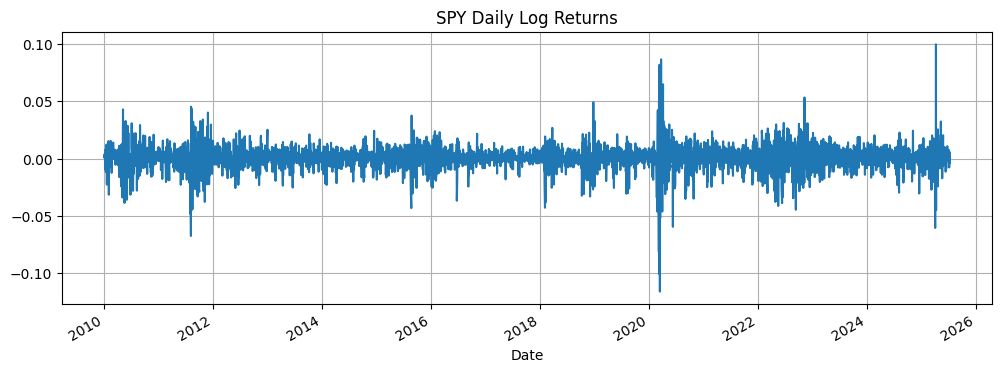

In [3]:
import matplotlib.pyplot as plt

df['log_return'].plot(figsize=(12, 4), title='SPY Daily Log Returns')
plt.grid(True)
plt.show()